In [25]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.decomposition import PCA
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import cv2
import sys
sys.path.append("../")

from utils.dataset import FreiHAND
from utils.model import ShallowUNet
from utils.trainer import Trainer
from utils.prep_utils import (
    blur_heatmaps,
    IoULoss,
    COLORMAP,
    config,
    N_KEYPOINTS,
    N_IMG_CHANNELS,
    get_norm_params,
    show_data,
    projectPoints
)

In [26]:
data = FreiHAND(config=config, set_type="all") ### load dataset for visualization

In [27]:
print(data[0]["image_raw"].shape) #to check the size of one image tensor before resizing
print(data[0]["image"].shape) #to check the size of one image tensor after resizing

torch.Size([3, 224, 224])
torch.Size([3, 128, 128])


#### taking first 50 images form the dataset to draw inferences

In [28]:
l = []
count=0
for i in range(len(data)):
    l.append(np.array(data[i]["image"].reshape(-1)))
    count+=1
    if count==50:
        break

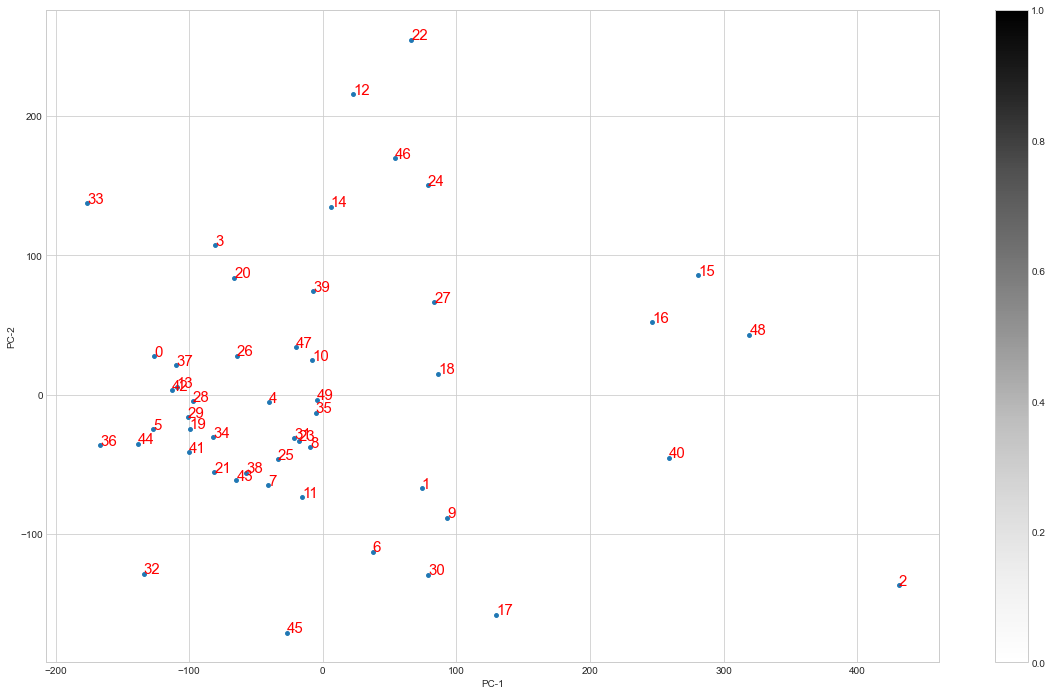

In [29]:

 
pca = PCA(2) # we need 2 principal components.
converted_data = pca.fit_transform(l)
 
converted_data.shape

plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (20,12))
c_map = plt.cm.get_cmap('jet', 10)
plt.scatter(converted_data[:, 0], converted_data[:, 1], s = 15,
            cmap = c_map)
plt.colorbar()
plt.xlabel('PC-1') , plt.ylabel('PC-2')
for i in range(50):
    plt.annotate(i,converted_data[i,:],color="red",size=15)

plt.show()

In [30]:
print(converted_data)

[[-126.0921995    27.35059952]
 [  74.02106212  -67.54026338]
 [ 430.95878969 -136.84171658]
 [ -80.47793076  107.57080724]
 [ -40.44067412   -5.63325075]
 [-126.86566516  -24.77689989]
 [  37.28978947 -112.89331307]
 [ -41.08094313  -64.98563107]
 [  -9.68394878  -37.63700468]
 [  93.13377475  -88.52004129]
 [  -7.75261897   24.47374941]
 [ -15.58885517  -73.88097992]
 [  22.78324281  216.10957959]
 [-109.47087267    5.38941125]
 [   5.85072411  134.91422598]
 [ 280.86531315   85.83602555]
 [ 246.43324781   52.07129633]
 [ 129.76037498 -158.28684648]
 [  86.37815132   15.02215332]
 [ -99.75166405  -24.50138273]
 [ -66.19784147   83.90267722]
 [ -81.14425187  -55.52808801]
 [  66.29741778  255.02491355]
 [ -17.97695689  -33.2321523 ]
 [  78.69683088  150.29640553]
 [ -33.48226218  -46.44893903]
 [ -64.27110721   27.8891258 ]
 [  83.44863817   66.59972127]
 [ -97.40363091   -4.62384298]
 [-101.10235332  -16.12853561]
 [  78.82947009 -129.35406316]
 [ -21.43844423  -31.49582322]
 [-133.9

In [31]:
print(pca.singular_values_) #singular values
print((pca.singular_values_)*(pca.singular_values_)) #EIGEN VALUES

[899.27170468 640.86627385]
[808689.59883059 410709.58096192]


In [32]:
pca.components_ #EIGEN VECTORS

array([[-4.00400266e-04, -1.98758632e-05, -5.44431598e-05, ...,
         4.25889834e-03,  4.21994665e-03,  3.96274721e-03],
       [ 1.76575130e-03,  1.54190915e-03,  1.80402736e-03, ...,
        -3.97251290e-03, -3.89981171e-03, -4.10531854e-03]])

### pca plot with 21 keypoints to 2 dimensions

In [33]:
data[0]["keypoints"]

tensor([[0.5870, 0.4175],
        [0.5145, 0.3753],
        [0.4727, 0.3776],
        [0.4219, 0.4164],
        [0.3526, 0.4645],
        [0.4546, 0.4703],
        [0.4115, 0.4994],
        [0.3769, 0.5178],
        [0.3526, 0.5465],
        [0.4338, 0.5319],
        [0.3867, 0.5725],
        [0.3501, 0.6014],
        [0.3297, 0.6432],
        [0.4266, 0.5675],
        [0.3813, 0.5981],
        [0.3402, 0.6290],
        [0.3092, 0.6603],
        [0.4168, 0.5866],
        [0.3776, 0.6251],
        [0.3431, 0.6572],
        [0.3219, 0.6954]], dtype=torch.float64)

In [34]:
la = []
count=0
for i in range(len(data)):
    la.append(np.array(data[i]["keypoints"].reshape(-1)))
    count+=1
    if count==50:
        break

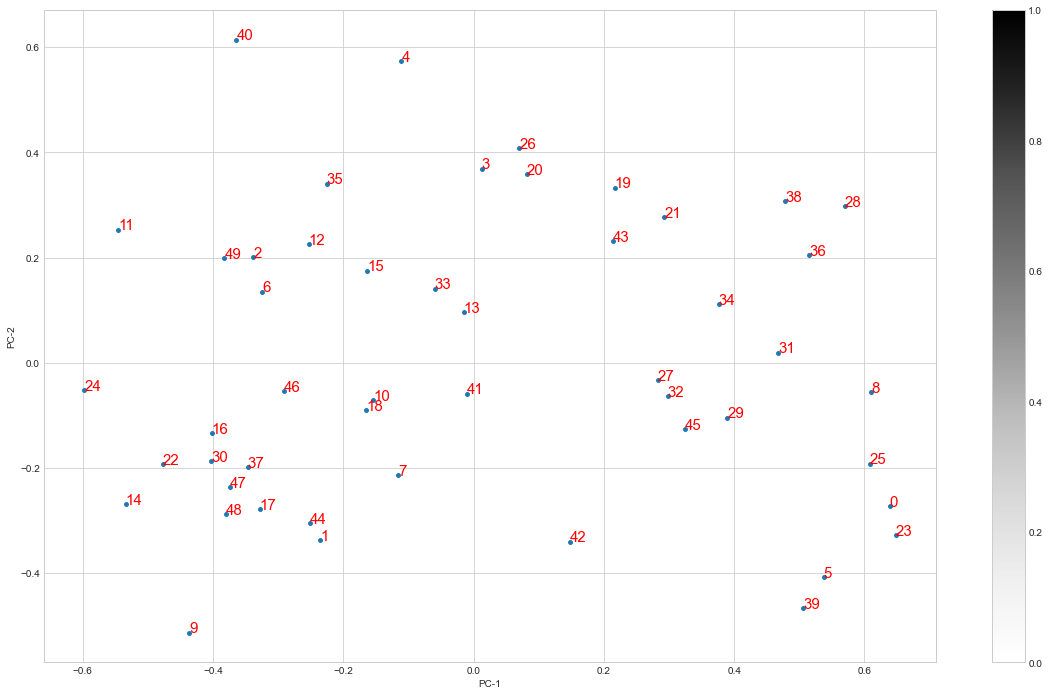

In [35]:
from sklearn.decomposition import PCA
 
pca = PCA(2) # we need 2 principal components.
converted_data = pca.fit_transform(la)
 
converted_data.shape

plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (20,12))
c_map = plt.cm.get_cmap('jet', 10)
plt.scatter(converted_data[:, 0], converted_data[:, 1], s = 15,
            cmap = c_map)
plt.colorbar()
plt.xlabel('PC-1') , plt.ylabel('PC-2')
for i in range(50):
    plt.annotate(i,converted_data[i,:],color="red",size=15)

plt.show()

In [36]:
print(pca.singular_values_) #singular values
print((pca.singular_values_)*(pca.singular_values_)) #EIGEN VALUES

[2.65505139 1.92729404]
[7.0492979  3.71446233]


In [37]:
pca.components_ #EIGEN VECTORS

array([[ 0.33202542, -0.11008772,  0.21340007, -0.07502588,  0.12595667,
        -0.04308992,  0.02765216, -0.0154989 , -0.08063095,  0.01956291,
        -0.04999254,  0.0157019 , -0.18089695,  0.04441423, -0.25289961,
         0.0628675 , -0.3222581 ,  0.09038595, -0.10248236,  0.02189638,
        -0.23441466,  0.04757347, -0.29815119,  0.06294507, -0.35325469,
         0.08282385, -0.0754079 ,  0.00205214, -0.18874156,  0.0344547 ,
        -0.24595972,  0.06070001, -0.28365624,  0.08902703, -0.04363877,
        -0.01772285, -0.1242573 ,  0.01006613, -0.16977905,  0.03275119,
        -0.21139088,  0.05810221],
       [ 0.10635829,  0.15560571,  0.05918891,  0.17687844,  0.01736188,
         0.19631459, -0.02731958,  0.18047585, -0.0781254 ,  0.17543774,
        -0.00899477, -0.01427776, -0.04624633, -0.09488392, -0.05279362,
        -0.13153028, -0.04239656, -0.15950541, -0.02417962, -0.12474054,
        -0.06042769, -0.21751548, -0.06335269, -0.25656919, -0.05254074,
        -0.29018